# Convolution neural networks

## Introduction
In this tutorial you will be learning about convolution neural networks (CNNs). CNNs have delievered state of the art performance especially in computer vision tasks. For example CNNs have dominated tasks like image classification, object detection, pose detection, human face generation. First, you will be motivated why we need CNNs, while highlighting the major components of a CNN at surface. Then you will be presented each of these components in detail. Finally, you will learn how the individual components come together by implementing a CNN with basic TensorFlow operations. We will also look at how we can detect overfitting in the model and fix it with dropout and batch-normalization. Finally we will conclude the chapter.

## Quick recap on fully-connected networks
A fully connected network (FCN) is a sequence of hidden layers wedged between an input layer and an output layer. Everything is connected to everything in two consecutive rows. FCNs are a to-go choice when it comes to low-dimensional data. 

![Fully connected network](../images/fcn.PNG)

## The great battle of high-dimensional data and fully-connected networks

Problem arises when FCNs have high-dimensional data as inputs. Below you can see some of these high dimensional data:

![High dimensional data](../images/spatial_data.PNG)

If you use a fully connected network to learn from these data you will face two main crippling issues.

### 1. The number of parameters in your network will blow up
Consider a neural network with a single hidden layer (with 1000 nodes) and a single output with two different input layers:
* A grayscale image of 28 x 28 (a single MNIST image) - 784 pixels
* A RGB image of 224 x 224 x 3 (a single ImageNet image) - 150528 pixels

Now let's do some simple calculations based on the above inputs:
* The first FCN will require $28\times 28\times 1000 + 1000 = \mathbf{785,000}$ $(\sim 3MB)$ parameters in the network 
* The second network requires $224\times 224\times 3\times 1000 + 1000 = \mathbf{150,529,000}$ $(\sim 574MB)$ parameters in the network

To give a bit of context, [VGG-16](https://arxiv.org/pdf/1409.1556.pdf) a SOTA **16**-layer image recognitio CNN only had $~138,000,000$ parameters.

### 2. You are losing important spatial information
In order to feed a high dimensional data point like an image to a FCN, you first need to unwrap that image to a 1-dimensional sequence. This can be illustrated as follows.

During this unwrapping you lose a fair bit of important spatial features:
i.e. nose of the cat is no longer sitting between the eyes

This transformation only makes the problem you are trying to solve harder.

## Enter CNNs!

Convolution neural networks are amazing because they solve both of these problems, i.e.:
* They are parameter efficient so you can have a large number of layers without stifling your GPU
* They preserve the spatial strucuture of data during the learning by using higher dimensional operations (e.g. 2 dimensional convolution)

![Convolution neural network](../images/cnn.png)

## Convolution operation

The convolution opeartion moves a convolution window (i.e. a kernel or a convolution filter) over the input. At each position on the image, the convolution window multiply the each window value with the overlapping input value, and sum the values up, to produce a single output value in the output layer. This is visualized below. 

### Why is convolution important?

But intuitively what kind of useful information does this this operation provide us? 

> It provides a representation whether a certain "feature" was present in the input or not

Assume you are attempting to classify whether a given image has a human face or not. We know that usually a human face has two eyes, a nose and a mouth. Assume on convolution filter represents the shape of an eye. In this scenario, the output layer will be computed as follows.

![Convolution-Intuition](../images/conv_intuitive.gif)

## Pooling operation

Pooling operation behaves in a very similar way to a convolution layer, however instead of taking the element-wise multiplication with the kernel and summing them together, the following operations are performed:
* *Average pooling*: Compute the average of the inputs that overlaps the kernel
* *Max-pooling*: Compute the maximum of the inputs that overlaps the kernel

### Pooling operation mathematically


### Why does pooling operation help a CNN?

> Pooling makes CNNs translation invariant

![Pooling intuitive](../images/pooling_intuitive.gif)

## Fully-connected layer

### Why fully-connected layers?

> Fully connected layer combines the localized features learnt by convolution layers to a global representation

> You cannot provide an output without a fully connected layer (in classification, object recognition, etc.)


## Implementing a CNN with TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests 
import tarfile
from io import StringIO
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

## Introduction to CIFAR-10 dataset

### Downloading the data

In [2]:
def download_cifar10(url):
    f = os.path.join('cifar10', "cifar-10-python.tar.gz")
    try:
        files = [
            os.path.join('cifar10', 'cifar-10-batches-py', 'meta_data'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_1'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_2'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_3'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_4'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_5'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'test_batch')
        ]
        print('Checking if the following files exists\n{}\n'.format(files))
        
        assert_msg = 'Some of the files were missing'
        assert all([os.path.exists(path) for path in files]), assert_msg
    except:
        try:
            print("Extracting {}".format(f))
            filename = os.path.join('cifar10', f)
            tar = tarfile.open(f, "r:gz")
            tar.extractall('cifar10')
            tar.close()
        except FileNotFoundError:
            print("Unable to find the file {}".format(f))
            print('Downloading CIFAR-10 from {}'.format(url))
            res = requests.get(url, stream=True)
            total_length = int(res.headers.get('content-length'))
            print('Detected data size: {}KB'.format(total_length))
            print('Making a directory cifar-10 to store data')
            if not os.path.exists('cifar10'):
                os.mkdir('cifar10')
            with open(f, 'wb') as f:
                print('Downloading data')
                for data in res.iter_content(chunk_size=1024*1024):
                    print('.',end='')
                    f.write(data)
        except Exception as ex:
            print(ex)
        
    print('\n\tDone')
    
download_cifar10('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')

Checking if the following files exists
['cifar10\\cifar-10-batches-py\\meta_data', 'cifar10\\cifar-10-batches-py\\data_batch_1', 'cifar10\\cifar-10-batches-py\\data_batch_2', 'cifar10\\cifar-10-batches-py\\data_batch_3', 'cifar10\\cifar-10-batches-py\\data_batch_4', 'cifar10\\cifar-10-batches-py\\data_batch_5', 'cifar10\\cifar-10-batches-py\\test_batch']

Extracting cifar10\cifar-10-python.tar.gz

	Done


### Visualizing data

* Training data size = 10000 x 5 = 50000 images
* Testing data size = 10000

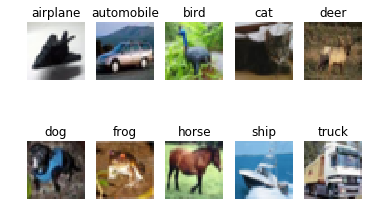

In [3]:
def vec2image(image_vec, normalize=False, global_mean=None, flip=False):
    """ Creating a 2D image from the 1D vector in the data """
    assert image_vec.size == 3072, "This (shape:{}) is not a CIFAR-10 Image".format(image_vec.shape)
    # TODO: Reshape image_vec to 32,32,3 size with order 'F' and assign it to image_mat
    img_mat = np.reshape(image_vec, (32, 32, 3), order='F')
    img_mat = np.rot90(img_mat,3)
    if normalize and global_mean:
        # TODO: Normalize the image by subtracting global_mean        
        # TODO: As a safety image use img_mat.astype(np.float32) to make sure the image is in fact float32
        img_mat = img_mat.astype(np.float32) - global_mean
    if flip:
        img_mat = np.flip(img_mat, axis=1)
    return img_mat

def get_image(file, class_label):
    """ Given a class get an image """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    
    for image_vec, label in zip(dict[b"data"], dict[b"labels"]):
        if label==class_label:
            img_mat = vec2image(image_vec)
            return img_mat
        else:
            continue
    return None

def get_label_to_name_map(file):
    """ Get a list of label names in the data """
    with open(file, 'rb') as f:
        label_dict = pickle.load(f, encoding='bytes')
        return [str(v,'utf-8') for v in label_dict[b"label_names"]]
    
    return None

# file batches.meta for label to string map
label_map = get_label_to_name_map(os.path.join('cifar10', 'cifar-10-batches-py', 'batches.meta'))

plt.subplots(2,5)
for cls in range(10):
    img = get_image(os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_1'), cls)
    plt.subplot(2,5,cls+1)
    plt.imshow(img)
    plt.title(label_map[cls])
    plt.axis('off')

## Implementing a CNN with TensorFlow

We will be using [FitNet4](https://arxiv.org/pdf/1511.06422.pdf). We will be defining three types of operations:
* Convolution operations
* Pooling operations
* Fully-connected operations

## Convolution operation

![Convolution](../images/conv_animation.gif)
Source: https://commons.wikimedia.org/wiki/File:3D_Convolution_Animation.gif


## Convolution with padding

Padding plays an important role in CNNs, as it enables to prevent automatic dimentionality reduction on width and height dimension. Padding appends zeros on the boundary of the input to make sure, input and output have the same size. For example without padding, if you have an image with `width=5` and `kernel=3`, we would get an output of size `3`. However, with padding, you can have an output of `width=5`.

![Convolution with padding](../images/conv_with_padding.png)

## Convolution with stride

Stride, on the other hand helps to enforce dimensionality reduction when needed. For example, it is desirable to reduce width and height of feature maps of the deeper layers. This acts as a natural regularizer and help deeper layers to learn high-level features. To achieve this, stride can be used. For example if you have an image with `width=6`, `kernel=2` and `stride=2`, then you will get an output with `width=3`.

![Convolution with stride](../images/conv_with_stride.png)

## Defining the network, losses and optimization

In [22]:
tf.reset_default_graph()
batch_size = None
n_classes = 10

# Input placeholder
tf_in = tf.placeholder(shape=[batch_size, 32, 32, 3], dtype=tf.float32, name='inputs') # <= 32,32,3

# Conv1 kernel
tf_conv1 = tf.get_variable('conv1', shape=[3, 3, 3, 32],  initializer=tf.initializers.glorot_uniform)

tf_out = tf.nn.conv2d(input=tf_in, filter=tf_conv1, strides=[1, 1, 1, 1], padding="SAME") # <= 32, 32, 32
tf_out = tf.nn.leaky_relu(tf_out)

# Pool2 output
tf_out = tf.nn.max_pool(value=tf_out, ksize=[1,2,2,1],  strides=[1, 2, 2, 1], padding="SAME") # <=16, 16, 32

# Conv3 output
tf_conv3 = tf.get_variable('conv3', shape=[3, 3, 32, 48],  initializer=tf.initializers.glorot_uniform) # <= 16, 16, 48
tf_out = tf.nn.conv2d(input=tf_out, filter=tf_conv3, strides=[1, 1, 1, 1], padding="SAME")
tf_out = tf.nn.leaky_relu(tf_out)

# Avg4 output
tf_out = tf.nn.avg_pool(value=tf_out, ksize=[1, 16, 16, 1],  strides=[1, 16, 16, 1], padding="SAME") # <= batch_size,1,1,48

# 1,1,48 => 48
tf_out = tf.reshape(tf_out, (-1, 48)) # <= batch_size, 48

tf_fulcon = tf.get_variable('fulcon5', shape=[48, 10],  initializer=tf.initializers.glorot_uniform) # <= 16, 16, 48
tf_pred = tf.matmul(tf_out, tf_fulcon)

In [23]:
# Defining softmax output
tf_pred_softmax = tf.nn.softmax(tf_pred)

# Loss function
tf_labels = tf.placeholder(name='labels', shape=[batch_size, 10], dtype=tf.int32)
tf_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_labels, logits=tf_pred)

# Optimizer
tf_opt = tf.train.MomentumOptimizer(learning_rate=1e-6, momentum=0.1).minimize(tf_loss)


## Loading data 

In [24]:
def input_fn(data_dir, batch_size, n_classes, mode, shuffle=True, random_image_flip=False):
    """ This function creates a generator which gives a batch of images, one-hot labels, and indices """
    
    # Get the file list for each train/validation/test datasets
    if mode == 'train':
        file_list = (os.path.join(data_dir, f) for f in ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4'])
    elif mode == 'valid':
        file_list = [os.path.join(data_dir, 'data_batch_5')]
    elif mode == 'test':
        file_list = [os.path.join(data_dir,'test_batch')]
    else:
        raise NotImplementedError
        
    for f in file_list:
        
        # Loading data in each file
        with open(f, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
            part_vec2image = partial(vec2image, normalize=True, global_mean=np.mean(dict[b"data"]))
        
        # Create a batch iteratively from the file
        for di in range(len(dict[b"labels"])//batch_size):
            if random_image_flip:
                part_vec2image = partial(
                    vec2image, normalize=True, global_mean=np.mean(dict[b"data"]),flip=np.random.choice([True, False]))
            
            # Shuffling the dataset (for training)
            if shuffle:
                idx = np.random.randint(0, len(dict[b"labels"]), batch_size)
            else:
                idx = np.arange(di*batch_size, (di+1)*batch_size)
                
            # Creating one-hot labels
            one_hot = np.zeros(shape=(batch_size, n_classes))
            one_hot[np.arange(batch_size), np.array(dict[b"labels"])[idx]] = 1.0
            
            yield np.apply_along_axis(part_vec2image, axis=1, arr=dict[b"data"][idx,:]), one_hot, idx


tr_data = input_fn(os.path.join('cifar10','cifar-10-batches-py'), 10, 10, mode='train', shuffle=False)
v_data = input_fn(os.path.join('cifar10','cifar-10-batches-py'), 10, 10, mode='valid', shuffle=False)
ts_data = input_fn(os.path.join('cifar10', 'cifar-10-batches-py'), 10, 10, mode='test', shuffle=False)

# Generating some training data
tr_i = 0
for bi, (b_img, b_lbl, b_idx) in enumerate(tr_data):
    if bi<3:
        print('({}) Indices: {}'.format(bi, b_idx))
        print('({}) Batch of data of size {} recieved'.format(bi, b_img.shape))
        print('({}) Labels {} received'.format(bi, np.argmax(b_lbl, axis=1).tolist()))
        Image.fromarray((b_img[0]-np.min(b_img[0])).astype(np.uint8)).save(os.path.join('cifar10', 'tr_img_{}.jpg'.format(bi)))
    tr_i += b_img.shape[0]
assert tr_i == 40000, 'Number of training samples is wrong'

# Generating some validation data
v_i = 0
for bi, (b_img, b_lbl, b_idx) in enumerate(v_data):
    if bi<3:
        print('({}) Indices: {}'.format(bi, b_idx))
        print('({}) Batch of data of size {} recieved'.format(bi, b_img.shape))
        print('({}) Labels {} received'.format(bi, np.argmax(b_lbl, axis=1).tolist()))
        Image.fromarray((b_img[0]-np.min(b_img[0])).astype(np.uint8)).save(os.path.join('cifar10', 'v_img_{}.jpg'.format(bi)))
    v_i += b_img.shape[0]
assert v_i == 10000, 'Number of valiation samples is wrong'

# Generating some testing data
ts_i = 0
for bi, (b_img, b_lbl, b_idx) in enumerate(ts_data):
    if bi<3:
        print('({}) Indices: {}'.format(bi, b_idx))
        print('({}) Batch of data of size {} recieved'.format(bi, b_img.shape))
        print('({}) Labels {} received'.format(bi, np.argmax(b_lbl, axis=1).tolist()))
        Image.fromarray((b_img[0]-np.min(b_img[0])).astype(np.uint8)).save(os.path.join('cifar10', 'ts_img_{}.jpg'.format(bi)))
    ts_i += b_img.shape[0]
assert ts_i == 10000, 'Number of test samples is wrong'

(0) Indices: [0 1 2 3 4 5 6 7 8 9]
(0) Batch of data of size (10, 32, 32, 3) recieved
(0) Labels [6, 9, 9, 4, 1, 1, 2, 7, 8, 3] received
(1) Indices: [10 11 12 13 14 15 16 17 18 19]
(1) Batch of data of size (10, 32, 32, 3) recieved
(1) Labels [4, 7, 7, 2, 9, 9, 9, 3, 2, 6] received
(2) Indices: [20 21 22 23 24 25 26 27 28 29]
(2) Batch of data of size (10, 32, 32, 3) recieved
(2) Labels [4, 3, 6, 6, 2, 6, 3, 5, 4, 0] received
(0) Indices: [0 1 2 3 4 5 6 7 8 9]
(0) Batch of data of size (10, 32, 32, 3) recieved
(0) Labels [1, 8, 5, 1, 5, 7, 4, 3, 8, 2] received
(1) Indices: [10 11 12 13 14 15 16 17 18 19]
(1) Batch of data of size (10, 32, 32, 3) recieved
(1) Labels [7, 2, 0, 1, 5, 9, 6, 2, 0, 8] received
(2) Indices: [20 21 22 23 24 25 26 27 28 29]
(2) Batch of data of size (10, 32, 32, 3) recieved
(2) Labels [2, 7, 0, 4, 1, 7, 7, 4, 4, 9] received
(0) Indices: [0 1 2 3 4 5 6 7 8 9]
(0) Batch of data of size (10, 32, 32, 3) recieved
(0) Labels [3, 8, 8, 0, 6, 6, 1, 6, 3, 1] received
(

## Running the CNN and Evaluating on CIFAR-10

In [25]:
epochs = 20
test_every = 1

def get_accuracy(y_true, y_pred):
    """ Get the accuracy of the network predictions """
    return np.sum((np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)))*1.0/y_true.shape[0]

def run_and_eval(
    tf_in, tf_out, tf_pred, tf_loss, tf_opt, epochs, 
    test_every, shuffle_data, tf_dropout_ph=None, dropout=None, augment_train=False
):
    """ Running and evaluation the CNN """
    
    accuracy_over_time = {'train':[], 'valid':[], 'test':[], "loss": []}
    
    with tf.Session() as sess:
        
        """ Initializing the variables """
        # TODO: Initialize both global and local variables
        tf.global_variables_initializer().run()

        print('Training for {} epochs (a single dot denotes a single epoch)'.format(epochs))
        print('Printing validation and test accuracies every {} epochs'.format(test_every))
        for ep in range(epochs):

            """ Resetting data generators every epoch"""
            
            tr_data = input_fn(
                os.path.join('cifar10','cifar-10-batches-py'), 64, 10, 
                mode='train', shuffle=shuffle_data, random_image_flip=augment_train
            )
            v_data = input_fn(
                os.path.join('cifar10','cifar-10-batches-py'), 64, 10, mode='valid', shuffle=False
            )
            ts_data = input_fn(
                os.path.join('cifar10', 'cifar-10-batches-py'), 64, 10, mode='test', shuffle=False
            )

            """ Training phase """
            losses, tr_accuracy = [],[]
            print('.', end='')
            for b_img, b_lbl,_ in tr_data:
                        
                    # TODO: Optimize the CNN on a single training batch
                    # Use sess.run on tf_opt to optimize the CNN (you will need to feed data to tf_in and tf_out)
                    # Compute predictions (pred) and loss (l) for a single batch for the fed data
                    _, pred, l = sess.run([tf_opt, tf_pred_softmax, tf_loss],
                            feed_dict={tf_in: b_img, tf_labels: b_lbl})
                    print(pred)
                    
                    losses.append(l)
                    tr_accuracy.append(get_accuracy(b_lbl, pred))

            if (ep+1)%test_every==0:
                print('\nEpoch: {}'.format(ep+1))
                print('\tMean train loss: {}'.format(np.mean(losses)))
                print('\tMean train accuracy: {}'.format(np.mean(tr_accuracy)))

                ''' Validation phase '''
                
                valid_accuracy = []
                for b_img, b_lbl, _ in v_data:
                    
                        
                    # TODO: Compute predictions using sess.run and assign it to preds
                    preds = sess.run(tf_pred_softmax, feed_dict={tf_in: b_img, tf_labels: b_lbl}) 
                    
                    valid_accuracy.append(get_accuracy(preds, b_lbl))

                print('\tMean valid accuracy: {}'.format(np.mean(valid_accuracy)))    

                ''' Testing phase '''
                test_accuracy = []
                for b_img, b_lbl, _ in ts_data:
                    
                        
                    # TODO: Compute predictions using sess.run and assign it to preds
                    preds = sess.run(tf_pred_softmax, feed_dict={tf_in: b_img, tf_labels: b_lbl})     
                    
                    test_accuracy.append(get_accuracy(preds, b_lbl))
                print('\tMean test accuracy: {}'.format(np.mean(test_accuracy)))    

                """ Collecting metrics"""
                accuracy_over_time["loss"].append(np.mean(losses))
                accuracy_over_time["train"].append(np.mean(tr_accuracy))
                accuracy_over_time["valid"].append(np.mean(valid_accuracy))
                accuracy_over_time["test"].append(np.mean(test_accuracy))
    return accuracy_over_time
    
accuracy_over_time = run_and_eval(tf_in=tf_in, tf_out=tf_out, tf_pred=tf_pred, tf_loss=tf_loss, tf_opt=tf_opt, epochs=epochs, test_every=test_every,  shuffle_data=False)
pd.DataFrame(accuracy_over_time).to_csv(os.path.join('cifar10','eval.csv'), index=False)

Training for 20 epochs (a single dot denotes a single epoch)
Printing validation and test accuracies every 1 epochs
.
Epoch: 1
	Mean train loss: 2.8151869773864746
	Mean train accuracy: 0.1619090544871795
	Mean valid accuracy: 0.1930088141025641
	Mean test accuracy: 0.2008213141025641
.
Epoch: 2
	Mean train loss: 2.170597791671753
	Mean train accuracy: 0.22122896634615385
	Mean valid accuracy: 0.2375801282051282
	Mean test accuracy: 0.24899839743589744
.
Epoch: 3
	Mean train loss: 2.0546131134033203
	Mean train accuracy: 0.2575120192307692
	Mean valid accuracy: 0.265625
	Mean test accuracy: 0.2764423076923077
.
Epoch: 4
	Mean train loss: 1.986433744430542
	Mean train accuracy: 0.2832532051282051
	Mean valid accuracy: 0.29126602564102566
	Mean test accuracy: 0.29507211538461536
.
Epoch: 5
	Mean train loss: 1.9380273818969727
	Mean train accuracy: 0.30481270032051283
	Mean valid accuracy: 0.3076923076923077
	Mean test accuracy: 0.31430288461538464
.
Epoch: 6
	Mean train loss: 1.899760127

## Detecting overfitting

Text(0.5, 1.0, 'Train/Valid/Test Accuracy for CIFAR-10')

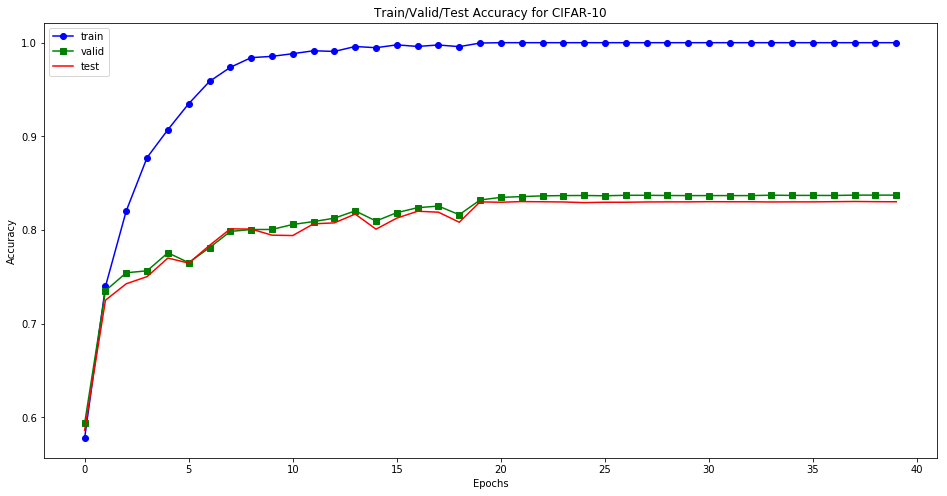

In [21]:
results_df = pd.read_csv(os.path.join('cifar10','eval.csv'))
plt.figure(figsize=(16,8))

# TODO: Plot the training / validation and testing accuracies using plt.plot
# Training use color blue and marker 'o'
# Validation use color green and marker 's'
# Testing use color red and no marker

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Valid/Test Accuracy for CIFAR-10')

## Improving 
* Better optimizers
* Dropout
* Data augmentation

In [9]:
tf.reset_default_graph()
batch_size = None
tf_dropout_ph = tf.placeholder(shape=[], dtype=tf.float32, name='dropout')
tf_in, tf_logits = build_graph(cnn_layers, [32,32,3], batch_size=batch_size, tf_dropout_ph=tf_dropout_ph)

n_classes = 10

# TODO: Define the followings
# tf_pred => softmax activation of tf_logits
# tf_out => Placeholder of [batch_size, n_classes] size
# tf_loss => mean of cross entropy loss between labels and logits
# tf_opt => a minimization operation that minimizes loss using tf.train.AdamOptimizer using learning rate 1e-4


Building the graph for layer conv1
	Building a convolution layer
		First convolution layer
	Defining non-linearity
Building the graph for layer conv2
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv3
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv4
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv5
	Building a convolution layer
	Defining non-linearity
Building the graph for layer pool6
	Building a pooling layer
		Type: max
Building the graph for layer conv7
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv8
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv9
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv10
	Building a convolution layer
	Defining non-linearity
Building the graph for layer conv11
	Building a convolution layer
	Defining non-linearity
Building 

In [10]:
epochs = 20
test_every =5
dropout = 0.5
accuracy_over_time = run_and_eval(
    tf_in=tf_in, tf_out=tf_out, tf_pred=tf_pred, 
    tf_loss=tf_loss, tf_opt=tf_opt, epochs=epochs, 
    test_every=test_every,  shuffle_data=True, 
    tf_dropout_ph=tf_dropout_ph, dropout=dropout, 
    augment_train=True
)
pd.DataFrame(accuracy_over_time).to_csv(os.path.join('cifar10','eval_improved.csv'), index=False)

Training for 200 epochs (a single dot denotes a single epoch)
Printing validation and test accuracies every 5 epochs
.....
Epoch: 5
	Mean train loss: 0.9814866185188293
	Mean train accuracy: 0.6477614182692307
	Mean valid accuracy: 0.6482371794871795
	Mean test accuracy: 0.6402243589743589
.....
Epoch: 10
	Mean train loss: 0.6564354300498962
	Mean train accuracy: 0.7722355769230769
	Mean valid accuracy: 0.7663261217948718
	Mean test accuracy: 0.7534054487179487
.....
Epoch: 15
	Mean train loss: 0.49309906363487244
	Mean train accuracy: 0.8310046073717948
	Mean valid accuracy: 0.7983774038461539
	Mean test accuracy: 0.7928685897435898
.....
Epoch: 20
	Mean train loss: 0.3742683231830597
	Mean train accuracy: 0.8727213541666666
	Mean valid accuracy: 0.8128004807692307
	Mean test accuracy: 0.8070913461538461
.....
Epoch: 25
	Mean train loss: 0.2929668426513672
	Mean train accuracy: 0.9015675080128205
	Mean valid accuracy: 0.8238181089743589
	Mean test accuracy: 0.8194110576923077
.....
Ep

## CNN vs improved CNN performance

Text(0.5, 1.0, 'Train/Valid/Test Accuracy for CIFAR-10')

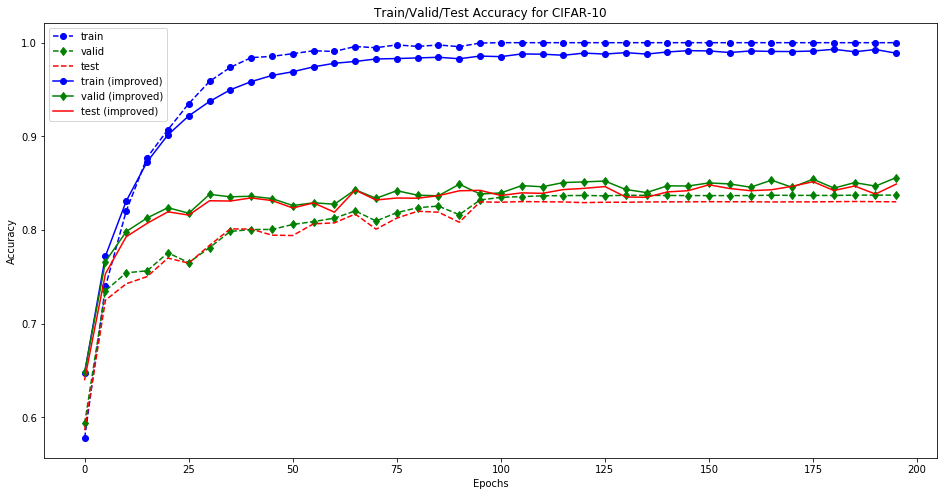

In [22]:
results_df = pd.read_csv(os.path.join('cifar10','eval.csv'))
results_improved_df = pd.read_csv(os.path.join('cifar10','eval_improved.csv'))
plt.figure(figsize=(16,8))
plt.plot(
    np.arange(0, results_df.shape[0]*test_every, test_every), 
    results_df["train"], color='blue', linestyle='--', 
    marker='o', label="train"
)
plt.plot(
    np.arange(0, results_df.shape[0]*test_every, test_every), 
    results_df["valid"], color='green', linestyle='--', 
    marker='d', label="valid"
)
plt.plot(
    np.arange(0, results_df.shape[0]*test_every, test_every), 
    results_df["test"], color='red', linestyle='--', label="test"
)
plt.plot(
    np.arange(0, results_improved_df.shape[0]*test_every, test_every), 
    results_improved_df["train"], color='blue', marker='o', label="train (improved)"
)
plt.plot(
    np.arange(0, results_improved_df.shape[0]*test_every, test_every), 
    results_improved_df["valid"], color='green', marker='d', label="valid (improved)"
)
plt.plot(
    np.arange(0, results_improved_df.shape[0]*test_every, test_every), 
    results_improved_df["test"], color='red', label="test (improved)"
)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Valid/Test Accuracy for CIFAR-10')

## Implementing a CNN with Keras

In [24]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Flatten, Dense
from tensorflow.python.keras import backend as K

In [33]:
tf.reset_default_graph()
K.clear_session()

""" Defining a model """

# TODO: Define a Keras sequential model
model = Sequential()

""" Adding layers """

# TODO: Add a Conv2D layer with 32 filters, kernel_size 3, stride 1, padding 'same' and 'relu' activation

# TODO: Add a MaxPool2D layer with pool_size 2, stride 2, padding 'same' 

# TODO: Add a Conv2D layer with 64 filters, kernel_size 3, stride 1, padding 'same' and 'relu' activation

# TODO: Add a MaxPool2D layer with pool_size 2, stride 2, padding 'same' 

# TODO: Add a Conv2D layer with 128 filters, kernel_size 3, stride 1, padding 'same' and 'relu' activation

# TODO: Add a AvgPool2D layer with pool_size 8, stride 8, padding 'same' 

# TODO: Add a Flatten layer

# TODO: Add a Dense layer with 10 outputs and activation softmax (optionally set input_shape )


""" Compiling the model with loss/optimizer """

# TODO: Compile the model where loss is categorical crossentropy and optimizer is adam

""" Fitting data """
tr_data = input_fn(
    os.path.join('cifar10','cifar-10-batches-py'), 64, 10, 
    mode='train', shuffle=True, random_image_flip=False
)
for b_img, b_lbl, _ in tr_data:
    
    # TODO: User train_on_batch function to train the model
    
    
model.summary()

Epoch 1/1
64/64 [==============================] - 2s 24ms/step - loss: 13.1978
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
______________________________________________________________